# [SC57 - Working with big, multi-dimensional geoscientific datasets in Python: a tutorial introduction to xarray](http://meetingorganizer.copernicus.org/EGU2017/session/25651)  
  
  
Original notebook by [Stephan Hoyer](http://stephanhoyer.com), Rossbypalooza, 2016.  

Edits by Edward Byers, Matthew Gidden and [Fabien Maussion](http://fabienmaussion.info/) for EGU General Assembly 2017, Vienna, Austria,  [Dr Chelle Gentemann](mailto:gentemann@esr.org), Earth and Space Research, USA and [Dr Marisol Garcia-Reyes](mailto:marisolgr@faralloninstitute.org) (multiple events) with help from @lewismc, [B.Storer](https://github.com/bastorer), and [M.Feen](https://github.com/melaniefeen).

# Structure of this tutorial

1. Opening data
1. Collocating satellite data with a cruise dataset



# 1. Key features of `xarray`

-------------------

## Import python packages

You are going to want numpy, pandas, matplotlib.pyplot and xarray

In [27]:
import warnings
warnings.simplefilter('ignore') # filter some warning messages

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean
from pyproj import Proj
import cartopy.crs as ccrs


import xarray as xr


#for search capabilites import podaacpy
import podaac.podaac as podaac
import podaac.podaac_utils as putil
# then create an instance of the Podaac class
p = podaac.Podaac()

## A nice cartopy tutorial is [here](http://earthpy.org/tag/visualization.html)

# Collocate a Saildrone cruise with Satellite Observations

### The Saildrone cruise is 2 months long.

`xarray`can open multiple files at once using string pattern matching.  
  
  In this case we open all the files that match our `filestr`, i.e. all the files for the 2080s. 
  
  Each of these files (compressed) is approximately 800 MB.

# Read in the Saildrone data


In [28]:
url = 'https://podaac-opendap.jpl.nasa.gov/opendap/hyrax/allData/insitu/L2/saildrone/Baja/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
ds_usv = xr.open_dataset(url)
#ds_usv #uncomment this line for information about the data (dimensions, data variables, attributes)

## The next section requires a manual input with the start and end time manually

In [29]:
str_start_time = '2018-04-12'
str_end_time = '2018-06-10'
str_start_time = '2018-04-12T02'
str_end_time = '2018-06-10T18'

Subset the Saildrone data using the time inputs from above.

In [30]:
ds_usv2 = ds_usv.isel(trajectory=0).swap_dims({'obs':'time'}).rename({'longitude':'lon','latitude':'lat'})
ds_usv_subset = ds_usv2.sel(time=slice(str_start_time,str_end_time)) 
start_time=pd.to_datetime(str(ds_usv2.time.min().data)).strftime('%Y-%m-%dT%H:%m:%SZ') 
end_time=pd.to_datetime(str(ds_usv2.time.max().data)).strftime('%Y-%m-%dT%H:%m:%SZ') 
ds_usv_subset 
print('start: ',start_time,'end: ',end_time)

start:  2018-04-11T18:04:00Z end:  2018-06-11T05:06:00Z


Text(0, 0.5, 'Latitude')

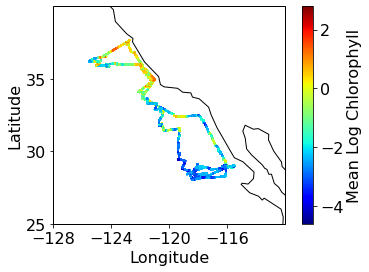

In [31]:
logchl = np.log(ds_usv_subset.CHLOR_MEAN) #take the log of the chlorophyll data

#plot the saildrone cruise track colored by the chlorophyll data
font = {'size' : 16}
plt.rc('font', **font)
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(ds_usv_subset.lon, ds_usv_subset.lat, s=3.0, c=logchl, edgecolor='none', cmap='jet')
ax.coastlines()
x1,x2,y1,y2 = -128,-112,25,40
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Mean Log Chlorophyll')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Collocate with Ocean Color Observations from the Ocean Color Web Opendap 
https://oceandata.sci.gsfc.nasa.gov/opendap/.

## This example pulls chlorophyll from MODIS Aqua Level 3 Standard Mapped Image Product.

The next section requires manual inputs from the user to build a url to call data from the Opendap. Inputs include the following:
* start and end dates (start_date, end_date)
* Variable (VAR)
* Algorithm (ALG)
* Binning period (BIN)
* Spatial resolution (SRES)


To run just the [tutorial on the Ocean Color data](../Chlorophyll/CHL_dap.ipynb)

In [32]:
## YYYY-MM-DD
start_date = np.datetime64(str_start_time[:10])
end_date   = np.datetime64(str_end_time[:10])

# variable to load
VAR = 'CHL'

# algorithm
ALG = 'chl_ocx'

# Binning period
BIN = '8D'  # DAY, 8D, MO, R32

# Spatial resolution
SRES = '9km'   # 4km, 9km



In [33]:
num_days = (end_date - start_date).tolist().days

# Track which days are kept
the_days = []

dap_urls = []

url_base = "https://oceandata.sci.gsfc.nasa.gov:443/opendap/MODISA/L3SMI/"


for ii in range(num_days):
    
    curr_date = start_date + ii
    
    curr_year = curr_date.tolist().year
    ref_date = np.datetime64('{0:d}-01-01'.format(curr_year))
    
    day_num = 1 + (curr_date - ref_date).tolist().days
    
    # We need to change the formatting a bit depending on the binning
    do = True
    if BIN == 'DAY':
        time_str = 'A{0:d}{1:03d}'.format(curr_year, day_num)
    elif BIN == '8D':
        if (int(day_num) - 1) % 8 == 0:
            targ_day = day_num + 7
            if targ_day > 365:
                targ_day = 365
            
            time_str = 'A{0:d}{1:03d}{2:d}{3:03d}'.format(curr_year, day_num, curr_year, targ_day)
        else:
            # There isn't an 8D set starting here
            do = False
    
    if do:
        file_url = url_base + \
                '{0:d}/{1:03d}/{2}'.format(curr_year, day_num, time_str) + \
                '.L3m_{0}_{1}_{2}_{3}'.format(BIN, VAR, ALG, SRES) + \
                '.nc'
    
        dap_urls += [file_url]
        
        the_days += [curr_date]
    
print('dap_urls containts {0:d} urls for {1} data.'.format(len(dap_urls), VAR))

dap_urls containts 7 urls for CHL data.


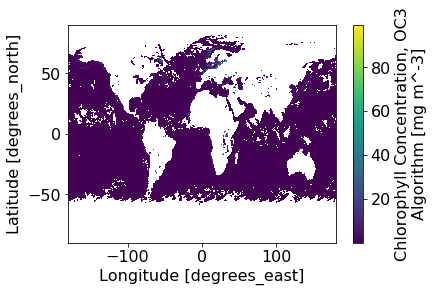

In [34]:
#test that the file you generate actually opens data by loading one time point
single_set = xr.open_dataset(dap_urls[0])

#and plot the data to see what it looks like!
single_set.chl_ocx.plot(
    x="lon",
    y="lat",
);

# Load in Satellite Sea Surface Temperature Data

### This tutorial originally used Multiscale Ultrahigh Resolution (MUR) SST, which is 0.01 degree resolution, but was updated to pull a daily product by NAVOCEANO on a 0.1 degree grid to increase run time! More information on the product can be found [here](https://cmr.earthdata.nasa.gov/search/concepts/C1268959235-PODAAC.html).

In [35]:
#dataset_id = 'PODAAC-GHGMR-4FJ04'  #MUR SST looked up on podaac website
dataset_id = 'PODAAC-GHK10-41N01'  #smaller data
gresult = p.granule_search(dataset_id=dataset_id,
                           start_time=start_time,
                           end_time=end_time,
                           items_per_page='100')
urls = putil.PodaacUtils.mine_opendap_urls_from_granule_search(gresult)
urls = [w[:-5] for w in urls]  #remove html from urls

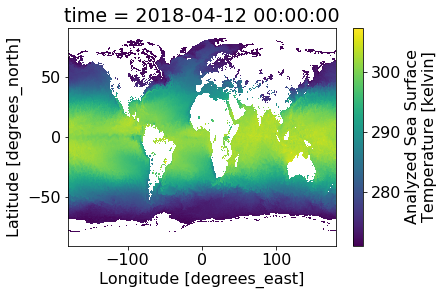

In [36]:
ds_sst = xr.open_mfdataset(urls,coords='minimal')
ds_sst

ds_sst.analysed_sst[0, ...].plot(
    x="lon",
    y="lat",
);

How big is all this data uncompressed? Will it fit into memory?
Use `.nbytes` / 1e9  to convert it into gigabytes

In [37]:
ds_sst.nbytes / 1e9  

4.0198541

## The NCEI trajectory format uses 'obs' as the coordinate.  This is an example of an 'older' style of data formatting that doesn't really mesh well with modern software capabilities. 

* So, let's change that by using [.swap_dims](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.swap_dims.html) to change the coordinate from `obs` to `time`
* Another thing, `latitude` and `longitude` are just long and annoying, lets [.rename](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.rename.html) them to `lat` and `lon`

* Finally, the first and last part of the cruise the USV is being towed, so let's only include data from `2018-04-12T02` to `2018-06-10T18`


# Xarray interpolation won't run on chunked dimensions.  
1. First let's subset the data to make it smaller to deal with by using the cruise lat/lons
    * Find the max/min of the lat/lon using `.lon.min().data`

1. Now load the data into memory (de-Dask-ify) it using `.load()`  


In [38]:
#Step 1 from above - this takes the lat and lon from the saildrone data and subsets the satellite sst
print('min max lat lon:', ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data,ds_usv_subset.lat.min().data,ds_usv_subset.lat.max().data)
lon_min,lon_max = ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data
lat_min,lat_max = ds_usv_subset.lat.min().data,ds_usv_subset.lat.max().data
subset_sat_sst = ds_sst.sel(lon=slice(lon_min,lon_max),
                  lat=slice(lat_max,lat_min))

#subset_sat_sst #uncomment this line for info on the dimensions and variables in the satellite sst

min max lat lon: -125.55297279999999 -115.5226624 28.0176832 37.6797408


Text(0, 0.5, 'Latitude')

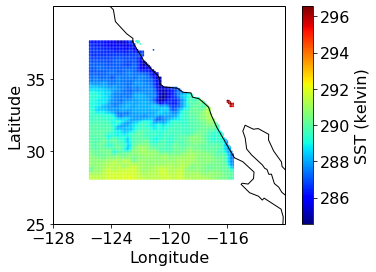

In [39]:
#Plot the satellite SST subset

xv, yv = np.meshgrid(subset_sat_sst.lon, subset_sat_sst.lat)
font = {'size' : 16}
plt.rc('font', **font)
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(xv, yv, s=3.0, c=subset_sat_sst.analysed_sst[0,:,:], edgecolor='none', cmap='jet')
ax.coastlines()
x1,x2,y1,y2 = -128,-112,25,40
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('SST (kelvin)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')





In [40]:
#this is now subsetting the ocean color satellite data
def preprocess_set(dset, time):
    return dset.sel(lon=slice(lon_min,lon_max),lat=slice(lat_max,lat_min))

data_sets = [preprocess_set(xr.open_dataset(url), ind) \
             for (url,ind) \
             in zip(dap_urls, np.arange(num_days))]

time_array = xr.DataArray(the_days, None, 'time', 'time')

subset_chl = xr.concat(data_sets, time_array)


In [ ]:
#Step 2 from above - load in the data subsets
subset_sat_sst.load()
subset_chl.load()
print() #comment this line for some output, but this keeps the work space nice and neat

In [ ]:
#plot the subset of chlorophyll satellite data

xv2, yv2 = np.meshgrid(subset_chl.lon, subset_chl.lat)

font = {'size' : 16}
plt.rc('font', **font)
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(xv2, yv2, s=3.0, c=(np.log(subset_chl.chl_ocx[0,:,:])), edgecolor='none', cmap='jet')
ax.coastlines()
x1,x2,y1,y2 = -128,-112,25,40
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Log Chl (mg/m^3)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Collocate In Situ USV data with the Satellite SST data and Ocean Color Data
There are different options when you interpolate.  First, let's just do a linear interpolation using [.interp()](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.interp.html#xarray.Dataset.interp)

`Dataset.interp(coords=None, method='linear', assume_sorted=False, kwargs={}, **coords_kwargs))`



In [17]:
#make sure they both have the same time stamp format otherwise the interpolation will fail
subset_sat_sst['time'] = subset_sat_sst.indexes['time'].to_datetimeindex()
#subset_sat_sst.time #uncomment this line to see that the satellite SST date format is correct


In [18]:
ds_collocated_sst = subset_sat_sst.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='linear')
ds_collocated_oc = subset_chl.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='linear')

In [19]:
dif_sst_lin = ds_collocated_sst.analysed_sst-(ds_usv_subset.TEMP_CTD_MEAN + 273.15)
print('mean difference = ',dif_sst_lin.mean().data)
print('STD = ',dif_sst_lin.std().data)

dif_oc_lin = ds_collocated_oc.chl_ocx-ds_usv_subset.CHLOR_MEAN
print('mean difference = ',dif_oc_lin.mean().data)
print('STD = ',dif_oc_lin.std().data)

mean difference =  0.20318721544742804
STD =  0.4635304209902711
mean difference =  -0.008291861931965853
STD =  0.5054514453052296


# Collocate USV data with SST data
There are different options when you interpolate.  First, let's just do a nearest point rather than interpolate the data
`method = 'nearest'`

In [20]:
ds_collocated_nearest_sst = subset_sat_sst.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='nearest')
ds_collocated_nearest_oc = subset_chl.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='nearest')

## Now, calculate the different in SSTs and print the [.mean()](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.mean.html#xarray.DataArray.mean) and [.std()](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.std.html#xarray.DataArray.std)
For the satellite data we need to use `sst` and for the USV data we need to use `TEMP_CTD_MEAN`

In [21]:
ds_collocated_nearest_sst.analysed_sst


<xarray.DataArray 'analysed_sst' (time: 85980)>
array([286.35, 286.35, 286.35, ...,    nan,    nan,    nan], dtype=float32)
Coordinates:
    lat         (time) float64 37.51 37.51 37.51 37.51 ... 37.68 37.68 37.68
    lon         (time) float64 -122.8 -122.8 -122.8 ... -122.7 -122.7 -122.7
  * time        (time) datetime64[ns] 2018-04-12T02:00:00 ... 2018-06-10T18:59:00
    trajectory  float32 1002.0
Attributes:
    long_name:      Analyzed Sea Surface Temperature
    standard_name:  sea_surface_temperature
    type:           depth 1m
    units:          kelvin
    valid_min:      -20
    valid_max:      350

In [22]:
ds_usv_subset.TEMP_CTD_MEAN

<xarray.DataArray 'TEMP_CTD_MEAN' (time: 85980)>
array([13.54 , 13.558, 13.573, ..., 10.581, 10.548, 10.541])
Coordinates:
    trajectory  float32 1002.0
  * time        (time) datetime64[ns] 2018-04-12T02:00:00 ... 2018-06-10T18:59:00
    lat         (time) float64 37.51 37.51 37.51 37.51 ... 37.68 37.68 37.68
    lon         (time) float64 -122.8 -122.8 -122.8 ... -122.7 -122.7 -122.7
Attributes:
    standard_name:              sea_water_temperature
    long_name:                  Seawater temperature
    units:                      degrees_c
    last_calibrated:            2017-12-14
    update_period:              Attribute edlided: Unsupported attribute type...
    model_product_page:         http://rdinstruments.com/product/ctd/citadel-...
    device_name:                Teledyne CTD (2632)
    installed_date:             2017-10-02T18:48:43Z
    nominal_sampling_schedule:  12s on, 48s off, centered at :00
    installed_height:           -0.6
    serial_number:              2632


In [23]:
dif_sst_near = ds_collocated_nearest_sst.analysed_sst-(ds_usv_subset.TEMP_CTD_MEAN + 273.15)
print('mean difference = ',dif_sst_near.mean().data)
print('STD = ',dif_sst_near.std().data)

dif_oc_near = ds_collocated_nearest_oc.chl_ocx-ds_usv_subset.CHLOR_MEAN
print('mean difference = ',dif_oc_near.mean().data)
print('STD = ',dif_oc_near.std().data)

mean difference =  0.20544484005976774
STD =  0.48167126451293674
mean difference =  0.004300322455089829
STD =  0.4741116726838073


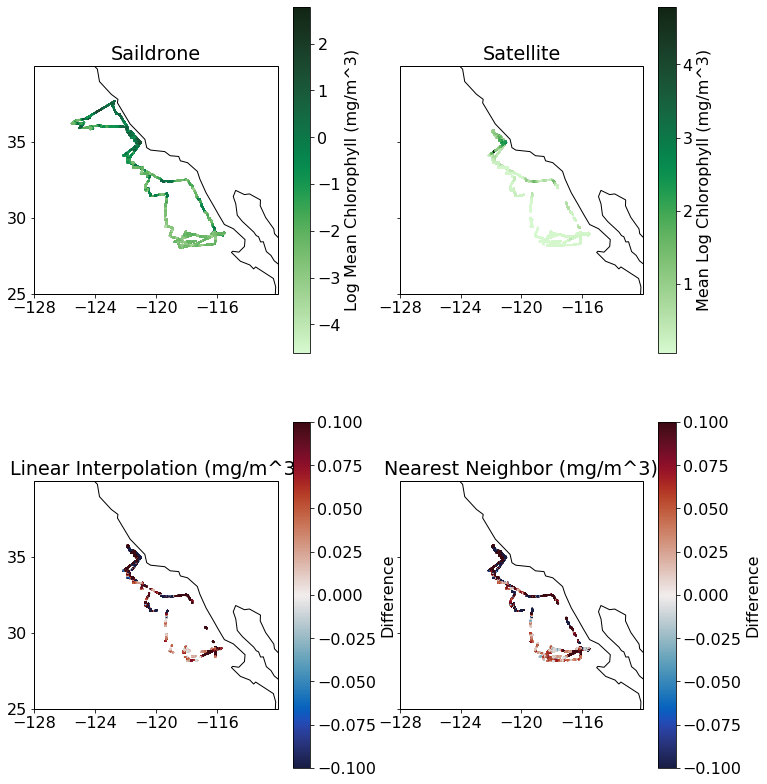

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(12,14),sharey = True,subplot_kw={'projection': ccrs.PlateCarree()})

plt.rc('font', **font)
ax=axes[0,0]
cs00 = axes[0,0].scatter(ds_usv_subset.lon, ds_usv_subset.lat, s=3.0, c=logchl, edgecolor='none', cmap='cmo.algae')
ax.coastlines()
cax = plt.colorbar(cs00,ax=axes[0,0])
cax.set_label('Log Mean Chlorophyll (mg/m^3)')
ax.set_title('Saildrone')



#plot the satellite cruise track colored by the chlorophyll data
plt.rc('font', **font)
ax =axes[0,1]
cs01 = ax.scatter(ds_usv_subset.lon, ds_usv_subset.lat, s=3.0, c=ds_collocated_nearest_oc.chl_ocx, edgecolor='none', cmap='cmo.algae')
ax.coastlines()
cax = plt.colorbar(cs01,ax=axes[0,1])
cax.set_label('Mean Log Chlorophyll (mg/m^3)')
ax.set_title('Satellite')


#plot the satellite cruise track colored by the chlorophyll data
plt.rc('font', **font)
ax =axes[1,0]
cv=np.percentile(np.abs(dif_oc_lin),75)
cs10 = ax.scatter(ds_usv_subset.lon, ds_usv_subset.lat, s=3.0, c=dif_oc_lin, edgecolor='none', cmap='cmo.balance',vmin=-cv,vmax=cv)
ax.coastlines()
cax = plt.colorbar(cs10,ax=axes[1,0])
cax.set_label('Difference')
ax.set_title('Linear Interpolation (mg/m^3)')

#plot the satellite cruise track colored by the chlorophyll data
plt.rc('font', **font)
ax = axes[1,1]
cv=np.percentile(np.abs(dif_oc_near),75)
cs11 = ax.scatter(ds_usv_subset.lon, ds_usv_subset.lat, s=3.0, c=dif_oc_near, edgecolor='none', cmap='cmo.balance',vmin=-cv,vmax=cv)
ax.coastlines()
cax = plt.colorbar(cs11,ax=axes[1,1])
cax.set_label('Difference')
ax.set_title('Nearest Neighbor (mg/m^3)')

for ax in axes.ravel():
    x1,x2,y1,y2 = -128,-112,25,40
    ax.set_xlim(x1,x2)
    ax.set_ylim(y1,y2)
    ax.set_xticks(np.arange(x1,x2,4))
    ax.set_yticks(np.arange(y1,y2,5))
    font = {'size' : 14}




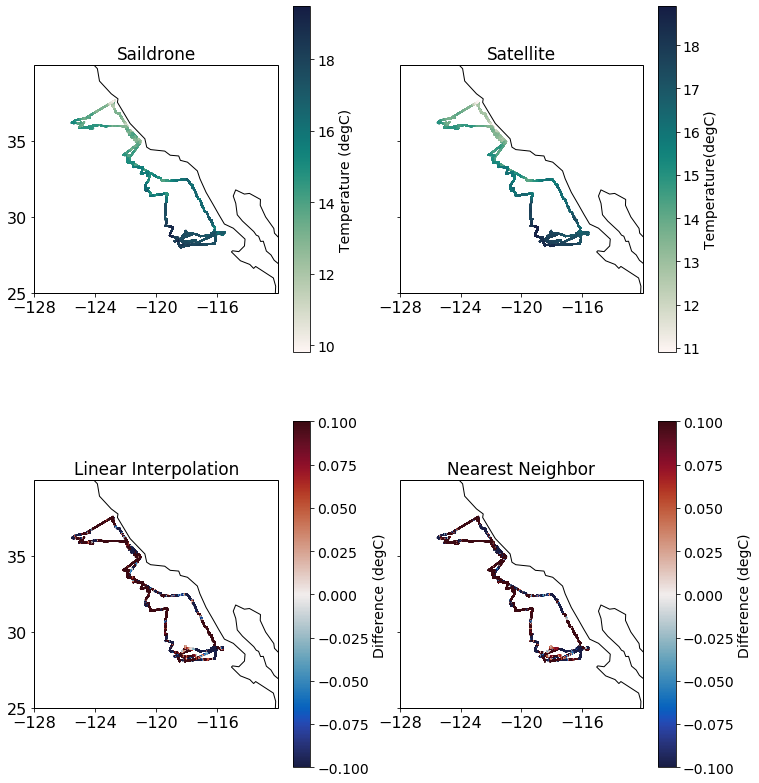

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(12,14),sharey = True,subplot_kw={'projection': ccrs.PlateCarree()})

plt.rc('font', **font)
ax=axes[0,0]
cs00 = axes[0,0].scatter(ds_usv_subset.lon, ds_usv_subset.lat, s=3.0, c=ds_usv_subset.TEMP_CTD_MEAN, edgecolor='none', cmap='cmo.tempo')
ax.coastlines()
cax = plt.colorbar(cs00,ax=axes[0,0])
cax.set_label('Temperature (degC)')
ax.set_title('Saildrone')



plt.rc('font', **font)
ax =axes[0,1]
cs01 = ax.scatter(ds_usv_subset.lon, ds_usv_subset.lat, s=3.0, c=ds_collocated_nearest_sst.analysed_sst - + 273.15, edgecolor='none', cmap='cmo.tempo')
ax.coastlines()
cax = plt.colorbar(cs01,ax=axes[0,1])
cax.set_label('Temperature(degC)')
ax.set_title('Satellite')


plt.rc('font', **font)
ax =axes[1,0]
cv=np.percentile(np.abs(dif_oc_lin),75)
cs10 = ax.scatter(ds_usv_subset.lon, ds_usv_subset.lat, s=3.0, c=dif_sst_lin, edgecolor='none', cmap='cmo.balance',vmin=-cv,vmax=cv)
ax.coastlines()
cax = plt.colorbar(cs10,ax=axes[1,0])
cax.set_label('Difference (degC)')
ax.set_title('Linear Interpolation')

plt.rc('font', **font)
ax = axes[1,1]
cv=np.percentile(np.abs(dif_oc_near),75)
cs11 = ax.scatter(ds_usv_subset.lon, ds_usv_subset.lat, s=3.0, c=dif_sst_near, edgecolor='none', cmap='cmo.balance',vmin=-cv,vmax=cv)
ax.coastlines()
cax = plt.colorbar(cs11,ax=axes[1,1])
cax.set_label('Difference (degC)')
ax.set_title('Nearest Neighbor')

for ax in axes.ravel():
    x1,x2,y1,y2 = -128,-112,25,40
    ax.set_xlim(x1,x2)
    ax.set_ylim(y1,y2)
    ax.set_xticks(np.arange(x1,x2,4))
    ax.set_yticks(np.arange(y1,y2,5))
    font = {'size' : 14}

In [26]:
plt.dif_oc_lin()

AttributeError: module 'matplotlib.pyplot' has no attribute 'dif_oc_lin'